We'll start our microbiome analysis by doing a high-level overview of the categories of interest. This will let us determine what categories it might be interesting to pursue.

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import scipy
import skbio
import seaborn as sn
import matplotlib.pyplot as plt
from skbio.stats.power import subsample_power, confidence_bound

import americangut.ag_dictionary as agdic
from americangut.ag_data import AgData
import americangut.notebook_environment as agenv
import americangut.power_plots as agpp

/Users/jwdebelius/anaconda/envs/americangut/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We'll start by selecting the dataset we plan to use. We need to pick a bodysite, or location 

In [9]:
bodysite = 'fecal'
sequence_trim = '100nt'
rarefaction_depth = '10k'

use_subset = True
use_one_sample = True

Next, we'll load the data, and remove outliers.

In [10]:
data = AgData(bodysite=bodysite, 
              trim=sequence_trim, 
              depth=rarefaction_depth, 
              sub_participants=use_subset, 
              one_sample=use_one_sample)

We'll also pick a metric to examine. This can be an alpha diveristy metric or a beta diversity metric. We'll also pick a function. If the metric selected is an alpha diversity metric (i.e. `PD_whole_tree_10k`, `shannon_10k`, `chao1_1k`), the test should be an alpha diversity test. A default alpha diversity test can be found in `americangut.power_plots.ag_alpha_test`. If the metric selected is a beta diversity metric (i.e. `unweighted_unifrac`), the test should handle distance matrices. A default test is provided in `americangut.power_plots.ag_beta_test`.

In [69]:
metric = 'unweighted_unifrac'
test = agpp.ag_alpha_test

Next, let's set up a directory where we will save our results.

In [16]:
save_dir = agenv.check_save_dir(data.data_set)
summary_fp = os.path.join(save_dir, 'summary_%s.p' % metric)
all_power_dir = os.path.join(save_dir, 'power/all/%s' % metric)
ext_power_dir = os.path.join(save_dir, 'power/extreme/%s' % metric)
agenv.check_dir(all_power_dir)
agenv.check_dir(ext_power_dir)

Next, let's write a quick function to summarize the data for all groups in the data.

In [17]:
def generate_summary(question, data, test, metric):
    """Summarizes information about the results"""
    results = {'name': question.name}
    
    # Gets the map, otu table and distance matrix for the question
    data.reload_files()
    data.drop_alpha_outliers()
    data.drop_bmi_outliers()
    data.clean_age()
    data.clean_group(question)
    if question.type == 'Clinical':
        question.order = ['Yes', 'No']
        question.extremes = ['Yes', 'No']
    data.filter_by_question(question)
    
    # Identfies the samples within each group
    grouped = data.map_.groupby(question.name).groups
    group_ids = [grouped[o] for o in question.order]
    extreme_ids = [grouped[o] for o in question.extremes]
    
    # Provides summary information
    results['all_groups'] = question.order
    results['all_size'] = [len(id_) for id_ in group_ids]
    results['ext_groups'] = question.extremes
    results['ext_size'] = [len(id_) for id_ in extreme_ids]

    # Calculates the p value for all the samples
    results['all_p_value'] = test(metric, question, data, group_ids,
                                  permutations=999)
    results['ext_p_value'] = test(metric, question, data, extreme_ids,
                                  permutations=999)
    
    # Calculates statistical power or loads it from file
    all_power_fp = os.path.join(all_power_dir, '%s.p') % question.name
    ext_power_fp = os.path.join(ext_power_dir, '%s.p') % question.name
    
#     if not os.path.exists(all_power_fp):
#         a_power, a_counts = subsample_power(
#             test=lambda x: test(metric, question, data, x, permutations=99),
#             samples=group_ids,
#             min_counts=5,
#             counts_interval=10,
#             max_counts=60,
#             num_runs=5,
#             num_iter=500,
#             )
#         with open(os.path.join(all_power_fp), 'w') as f_:
#             pickle.dump((question.name, question.order, metric, a_power, a_counts),
#                         f_)
#     else:
    with open(os.path.join(all_power_fp), 'r') as f_:
        (name, order, metric, a_power, a_counts) = pickle.load(f_)

    # Calculates the effect size
    a_eff = agpp.z_effect(a_counts, a_power)
    if (a_power > 0.2).any():
        results['all_effect_mean'] = a_eff.mean()
        results['all_effect_ci'] = confidence_bound(a_eff)
    else:
        results['all_effect_mean'] = np.nan
        results['all_effect_ci'] = np.nan
        
#     if not os.path.exists(ext_power_fp):
#         e_power, e_counts = subsample_power(
#             test=lambda x: test(metric, question, data, x, permutations=99),
#             samples=extreme_ids,
#             min_counts=5,
#             counts_interval=10,
#             max_counts=60,
#             num_runs=5,
#             num_iter=500,
#             )
#         with open(os.path.join(ext_power_fp), 'w') as f_:
#             pickle.dump((question.name, question.order, metric, e_power, e_counts),
#                         f_)
#     else:
    with open(os.path.join(ext_power_fp), 'r') as f_:
        (name, order, metric, e_power, e_counts) = pickle.load(f_)

    # Calculates the effect size
    e_eff = agpp.z_effect(e_counts, e_power)
    if (a_power > 0.2).any():
        results['ext_effect_mean'] = e_eff.mean()
        results['ext_effect_ci'] = confidence_bound(e_eff)
    else:
        results['ext_effect_mean'] = np.nan
        results['ext_effect_ci'] = np.nan
    
    return results

Now, let's apply that function to our data, and save the output.

In [21]:
summary = []
for name in sorted(agdic.dictionary.keys()):
# for name in ['ANTIBIOTIC_HISTORY', 'BMI_CAT', 'IBD']:
    if use_subset and name in {'ANTIBIOTIC_HISTORY', 'DIABETES', 'BMI_CAT', 'IBD'}:
        continue
    question = agdic.ag_dictionary(name)
    if question.type == 'Continous':
        continue
    results = generate_summary(question, data, test, metric) 
    summary.append(results)

We'll look for categories that have clear effect sizes.

In [20]:
summary_df = pd.DataFrame(summary).set_index('name')
summary_df.to_csv('/Users/jwdebelius/Desktop/subset_%s.txt' % metric, sep='\t', na_rep='NA')

In [72]:
summary_df = pd.read_csv('/Users/jwdebelius/Desktop/subset_%s.txt' % metric, 
                         sep='\t', na_values='NA', index_col='name')

In [75]:
with open('/Users/jwdebelius/Desktop/ag_summary/subset/all_power/unweighted_unifrac/SLEEP_DURATION.p', 'r') as f_:
    sleep = pickle.load(f_)

In [77]:
name, order, metric, power, counts = sleep

In [78]:
eff = agpp.z_effect(counts, power)

In [80]:
eff.mean()

0.16949458699514922

In [81]:
summary_df.loc['SLEEP_DURATION', 'all_effect_mean'] = eff.mean()
summary_df.loc['SLEEP_DURATION', 'all_effect_ci'] = confidence_bound(eff)

Finally, let's pick some of the categories to make a power curve.

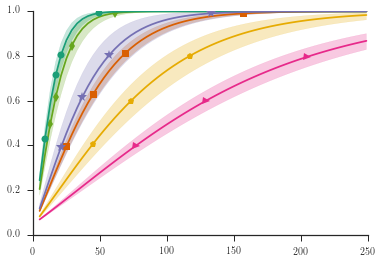

In [92]:
% matplotlib inline

from matplotlib import rcParams
sn.set_style('ticks', {'axes.facecolor': 'none'})
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

ax = plt.axes()

predict = np.arange(5, 251, 4)

# categories = ['AGE_CAT', 'BOWEL_MOVEMENT_QUALITY', 'SLEEP_DURATION', 'TYPES_OF_PLANTS', 'EXERCISE_FREQUENCY',
#               'ANTIBIOTIC_HISTORY', 'IBD', 'BMI_CAT'
#               ]

categories = ['TYPES_OF_PLANTS', 'BOWEL_MOVEMENT_QUALITY', 'AGE_CAT', 'EXERCISE_FREQUENCY', # 'SLEEP_DURATION',
              'CHICKENPOX', 'FLOSSING_FREQUENCY']

colors = ['#66a61e', '#d95f02', '#1b9e77', '#7570b3', '#e7298a', '#e6ab02', '#a6761d']
# colors = ['#1b9e77', '#d95f02', '#7570b3', '#66a61e', '#e7298a',
#           '#e6ab02', '#a6761d', '#666666']
#          ]
markers = ['d', 's', 'o', '*', '>', 'p']
#            '>', 'p', 'x'
marker_size = [7, 7, 7, 10, 7, 7, 7
#                7, 7, 7
              ]

lines = []
wpoints = []
for category, color, marker, ms in zip(*(categories, colors, markers, marker_size)):
    power = agpp.z_power(predict, summary_df.loc[category, 'ext_effect_mean'])
    lower = agpp.z_power(predict, summary_df.loc[category, 'ext_effect_mean'] - summary_df.loc[category, 'ext_effect_ci'])
    upper = agpp.z_power(predict, summary_df.loc[category, 'ext_effect_mean'] + summary_df.loc[category, 'ext_effect_ci'])
    points = np.array([np.min(np.arange(0, len(predict))[power > point])
                       for point in [0.39, 0.59, 0.79, 0.99] if (power > point).any()])
    ax.fill_between(predict,
                    lower,
                    upper,
                    alpha=0.25,
                    color=color,
                    )
    l = ax.plot(predict, power, color=color)
#     lines.append(l[0])
    p = ax.plot(predict[points], power[points], linestyle='None', marker=marker, color=color, ms=ms)
    wpoints.append(p[0])

sn.despine()


# # # ax.legend(['Age', 'Feces firmness', 'Nightly Sleep', 'Number of Types of Plants consumed', 'Exercise Frequency'])
# ax.legend(
# #     lines, 
#     wpoints,
# #     categories,
#     ['Plants Consumed', 'Feces firmness', 'Age', 'Exercise Frequency', 'Nightly Sleep',],
#     loc=4,
#     fontsize=12
#     )
# ax.set_xticklabels(map(int, ax.get_xticks()), size=12)
# ax.set_xlabel('Number of Samples per group', size=15)
# ax.set_yticklabels(ax.get_yticks(), size=12)
# ax.set_ylabel('Statistical Power', size=15)
# ax.set_title('PD Whole Tree Diversity')

# ax.figure.savefig('/Users/jwdebelius/Desktop/PD_whole_tree_sub10k.pdf', dpi=300)